In [1]:
import os
import sys
import pandas
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from scipy import stats
from statsmodels.stats.multitest import multipletests
from sklearn.model_selection import train_test_split,KFold, cross_val_predict
from sklearn.decomposition import PCA
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score, mean_absolute_error
sys.path.insert(0,'/Users/jacobv/git/data_driven_pathology/')
import CrossDecomp as xd

/Users/jacobv/jakepy/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# Get data

In [3]:
# from scipy.io import loadmat
# bd = loadmat(filepath)
# filepath = '/Users/jacobv/Science/PLS_GXP/Mouse/brainDivision.mat'
# bd['brainDivision'][0][0][0][0][0][0].shape

In [5]:
filepath = '/Users/jacobv/Science/PLS_GXP/Mouse/voxelGeneExpression_P14.mat'
arrays = {}
f = h5py.File(filepath)
for k, v in f.items():
    arrays[k] = np.array(v)

In [6]:
arrays.keys()

dict_keys(['#refs#', '#subsystem#', 'coOrds', 'geneIDs', 'geneInfo', 'voxGeneMat', 'voxLabelTable'])

In [7]:
coords = pandas.DataFrame(arrays['coOrds'])
print(coords.shape)
#print(arrays['geneIDs'].shape)
exp = pandas.DataFrame(arrays['voxGeneMat'])
print(exp.shape)
gdf = pandas.read_csv('/Users/jacobv/Science/PLS_GXP/Mouse/AMBAGeneInfo.csv')
print(gdf.shape)
vdf = pandas.read_csv('/Users/jacobv/Science/PLS_GXP/Mouse/AMBAvoxLabelTable.csv')
print(vdf.shape)

(3, 24213)
(2069, 24213)
(2015, 7)
(24213, 11)


In [8]:
# Match exp to gdf
eids = arrays['geneIDs'].astype(int)[0]
missing = list(set(eids) - set(gdf.entrezID.values))
print(len(missing),'missing from gdf')
gdf.loc[:,'orig_index'] = gdf.index.values
gdf.index = gdf.entrezID.values
gdf = gdf.reindex(eids)
gdf.entrezID = gdf.index
gdf.index = range(len(gdf))

54 missing from gdf


In [9]:
# fill in missing genes
hlog = pandas.read_csv('/Users/jacobv/Science/PLS_GXP/Mouse/HomoloGene ID	Common Organism Name	NCBI Taxon ID	S',
                      sep='\t')
hmouse = hlog[hlog['Common Organism Name']=='mouse, laboratory']

In [10]:
missing_stack = hmouse[hmouse['EntrezGene ID'].isin(missing)]
for m in missing:
    if m not in missing_stack['EntrezGene ID'].values: 
        print('couldnt find',m)
    else:
        gdf.loc[gdf.entrezID==m,'acronym'
               ] = missing_stack.loc[missing_stack['EntrezGene ID']==m,
                                    'Symbol']

couldnt find 627415


#### clean up exp dataframe

In [11]:
todrop = []
for col in exp.columns:
    if not any(pandas.notnull(exp[col].values)):
        todrop.append(col)

In [12]:
exp.drop(todrop,axis=1,inplace=True)
exp.shape

(2069, 24044)

In [13]:
res = pandas.DataFrame(index=exp.index)
for i,row in exp.iterrows():
    n = len([x for x in row.values if pandas.notnull(x)])
    res.loc[i,'n'] = n
res.loc[:,'p'] = res.n.values / exp.shape[1]

In [14]:
sns.displot(res.p)

original


log


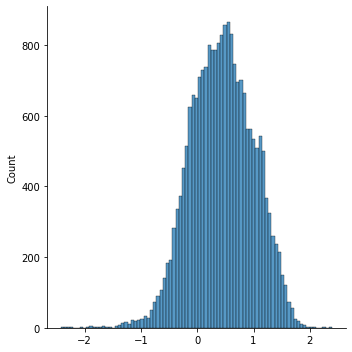

original


log


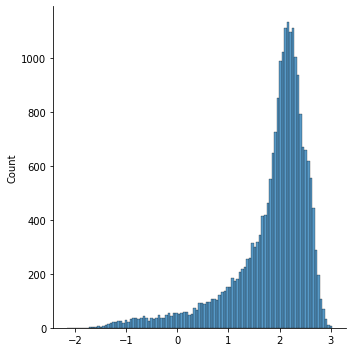

original


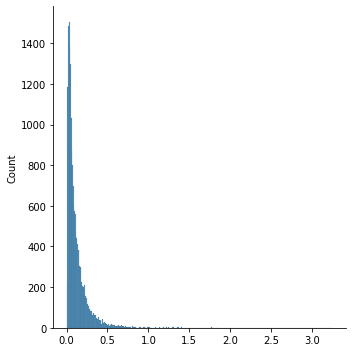

log


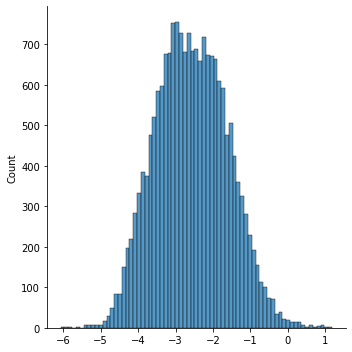

original


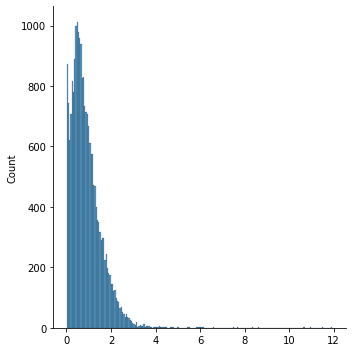

log


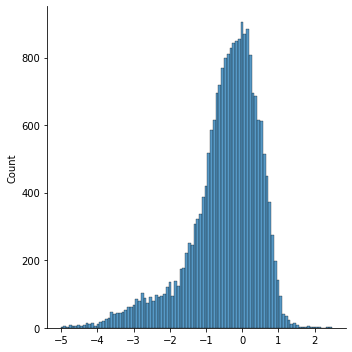

original


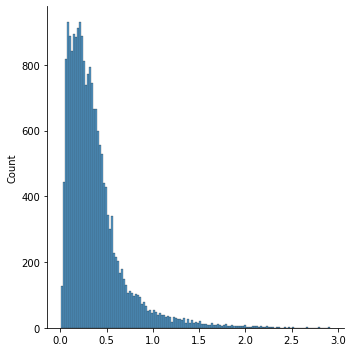

log


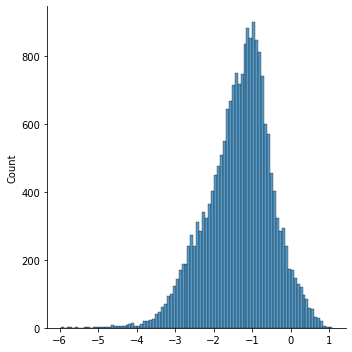

original


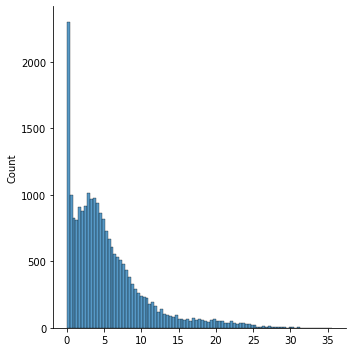

log


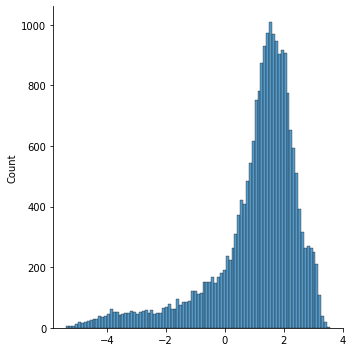

original


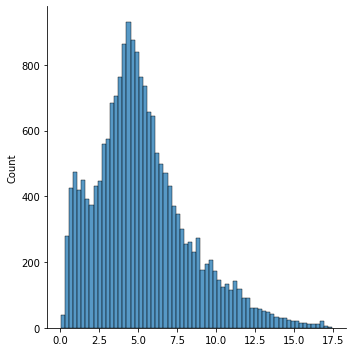

log


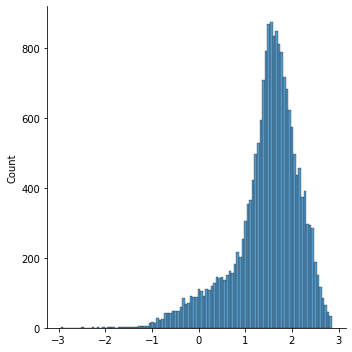

original


log


original


log


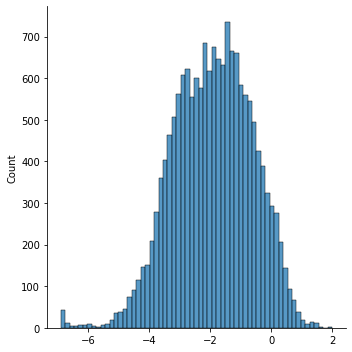

original


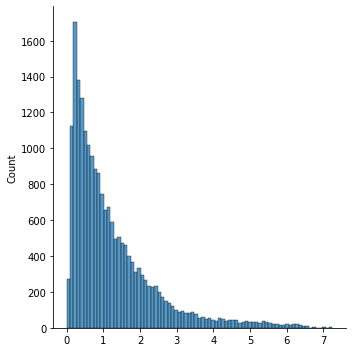

log


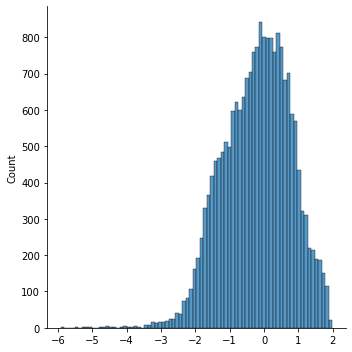

In [15]:
for i in range(10):
    print('original')
    sns.displot(exp.loc[i].dropna().values)
    plt.show()
    print('log')
    sns.displot(np.log(exp.loc[i].dropna().values+0.001))
    plt.show()

#### Do some imputation

In [89]:
### Considerations: Do i Log transform everything?
### How long is this stuff going to take?
imputed = {}

In [90]:
%%time
# simple imputer
imputed.update({'SI':SimpleImputer(strategy='median'
                                  ).fit_transform(exp.values)})


CPU times: user 6.42 s, sys: 1.12 s, total: 7.54 s
Wall time: 7.55 s


In [91]:
%%time
# knn
imputed.update({'KNN':KNNImputer().fit_transform(exp.values)})

CPU times: user 3min 32s, sys: 17.7 s, total: 3min 49s
Wall time: 3min 35s


In [92]:
#pandas.to_pickle(imputed,'/Users/jacobv/Science/PLS_GXP/Mouse/imputed_gxp.pk')

In [ ]:
%%time
# iterative imputer
imputed.update({'II':IterativeImputer().fit_transform(exp.values)})

In [16]:
imputed = pandas.read_pickle('/Users/jacobv/Science/PLS_GXP/Mouse/imputed_gxp.pk')

In [17]:
iexp = pandas.DataFrame(imputed['KNN'],
                        index=exp.index,columns=exp.columns)

In [18]:
coords = coords.T.loc[iexp.columns]

In [19]:
coords.columns = ['y','z','x']

In [20]:
coords.head()

y     z    x
0  36.0  12.0  4.0
1  37.0  12.0  4.0
2  38.0  12.0  4.0
3  39.0  12.0  4.0
4  40.0  12.0  4.0

# Quick mouse PLS

In [21]:
from sklearn.decomposition import PCA

In [22]:
pcamod = PCA(n_components=100, random_state=123).fit(iexp.T)
sum(pcamod.explained_variance_ratio_)

0.9111242047125085

(0.0, 10.0)

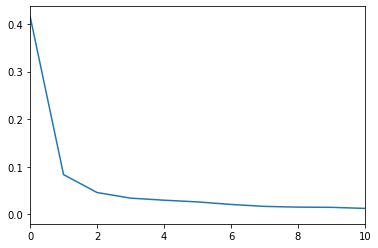

In [44]:
plt.plot(pcamod.explained_variance_ratio_)
plt.xlim(0,10)

In [45]:
pcamod.explained_variance_ratio_.round(3)

array([0.416, 0.083, 0.046, 0.034, 0.03 , 0.026, 0.021, 0.017, 0.015,
       0.015, 0.012, 0.011, 0.01 , 0.008, 0.008, 0.007, 0.006, 0.005,
       0.005, 0.005, 0.005, 0.005, 0.004, 0.004, 0.004, 0.004, 0.003,
       0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.002, 0.002,
       0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002,
       0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001])

In [25]:
pca_tfm.shape

(24044, 100)

In [23]:
pca_tfm = pandas.DataFrame(pcamod.transform(iexp.T),
                          index=iexp.columns)


In [24]:
vdf = vdf.loc[iexp.columns]

In [25]:
brainpart = ['Forebrain' if vdf.loc[x,'isForebrain']==1 else\
             'Midbrain' if vdf.loc[x,'isMidbrain']==1 else\
             'Hindbrain' if vdf.loc[x,'isHindbrain']==1 else\
             'Other' for x in vdf.index]
vdf.loc[:,'BrainPart'] = brainpart

In [70]:
vdf.BrainPart.value_counts()

Forebrain    16932
Hindbrain     5679
Midbrain      1433
Name: BrainPart, dtype: int64

In [48]:
pca_tfm.shape

(24044, 100)

In [26]:
jnk = pandas.DataFrame(pca_tfm,copy=True)
jnk.loc[:,'BrainPart'] = vdf.BrainPart.values

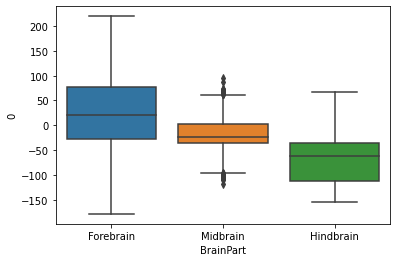

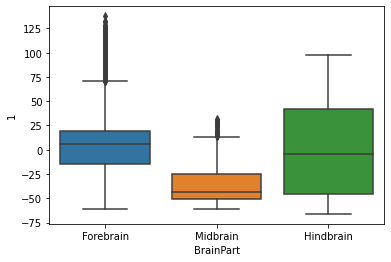

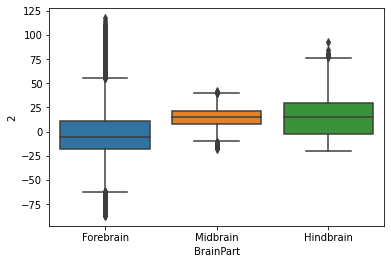

In [52]:
for i in range(5):
    sns.boxplot(x='BrainPart',y=pca_tfm.columns[i],data=jnk,
                order=['Forebrain','Midbrain','Hindbrain'])
    plt.show()

In [53]:
del(jnk)

In [27]:
tr,te = train_test_split(pca_tfm, stratify=vdf.BrainPart.values, 
                         random_state=123)
tr_y = coords.loc[tr.index]
te_y = coords.loc[te.index]

In [41]:
from sklearn.model_selection import KFold

ncs = 3
nc_chooser = pandas.DataFrame(index = range(ncs*1), columns = ['nc', 'estimator', 'r2','mae'])
i=0
for k,nc in enumerate(range(1,ncs+1)):
    print(nc)
    estimators = {'PLSR': PLSRegression(n_components=nc), }
#    nc_chooser.loc[k*3:k*3+2,'nc'] = [nc]*3
    for lab, estimator in estimators.items():
        for it in range(10):
            cv=KFold(n_splits=10,shuffle=True,random_state=123+it)
            pred = cross_val_predict(estimator, tr, tr_y, 
                                    groups = vdf.loc[tr.index].BrainPart.values, 
                                     cv=cv)
            nc_chooser.loc[i, 'r2'] = r2_score(y_true=tr_y, y_pred=pred)
            nc_chooser.loc[i, 'mae'] = mean_absolute_error(y_true=tr_y, y_pred=pred)
            nc_chooser.loc[i, 'estimator'] = lab
            nc_chooser.loc[i,'nc'] = nc
            nc_chooser.loc[i,'iter'] = it
            i+=1

1
2
3


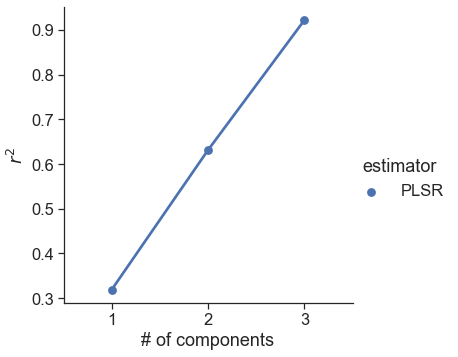

In [42]:
sns.set(font_scale=1.5)
sns.set_style('ticks')

sns.catplot(x = 'nc', y='mae', hue = 'estimator', 
               data=nc_chooser,aspect=1,kind='point')
plt.ylabel('mean absolute error')
plt.xlabel('# of components')
# plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/Figs/estimator_selection_cv_mae_rkf.pdf', 
#             bbox_inches='tight')
plt.show()

sns.catplot(x = 'nc', y='r2', hue = 'estimator', 
               data=nc_chooser[nc_chooser.nc<5],
               aspect=1,kind='point')
plt.ylabel('$r^{2}$')
plt.xlabel('# of components')
# plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/Figs/estimator_selection_cv_r2_rkf.pdf', 
#             bbox_inches='tight')
plt.show()

finished iteration 0
finished iteration 100
finished iteration 200
finished iteration 300
finished iteration 400
finished iteration 500
finished iteration 600
finished iteration 700
finished iteration 800
finished iteration 900


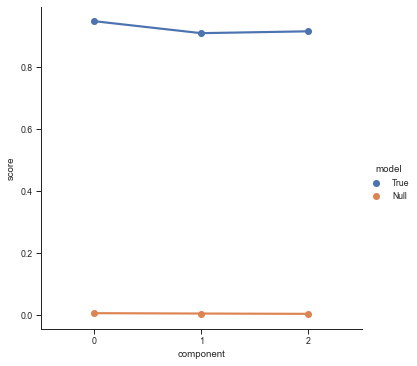

component 0: p = 0.001  ***
component 1: p = 0.001  ***
component 2: p = 0.001  ***


In [45]:
pls_mod = PLSRegression(n_components=3)
pls_mod.fit(tr,tr_y)
results, comp_sig = xd.evaluate_components(pls_mod, tr, tr_y, n_iterations=1000)

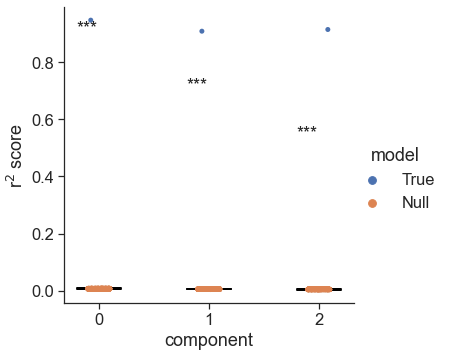

In [46]:
sns.set(font_scale=1.5)
sns.set_style('ticks')
sns.catplot(x='component', y='score', hue='model', data=results)
plt.text(-0.20,0.9,'***')
plt.text(0.80,0.7,'***')
plt.text(1.80,0.53,'***')
plt.ylabel('r$^2$ score')
for c in range(len(results.component.unique())):
    cvals = results[(results.model=='Null')&(results.component==c)
                ].score.sort_values().values
    cmin = cvals[25]
    cmax = cvals[975]
    plt.plot([c-.2,c+.2],[cmin,cmin],lw=2,c='black')
    plt.plot([c-.2,c+.2],[cmax,cmax],lw=2,c='black')
# plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/Figs/sig_componentsTR.pdf',
#              bbox_inches='tight')

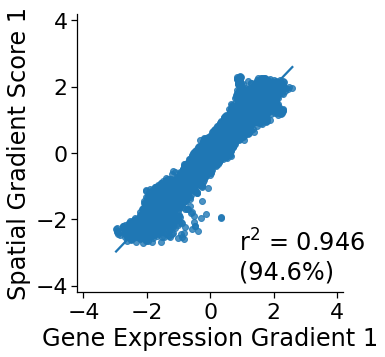

r2 = 0.9462970130031362, percent of total = 0.9462970130031362


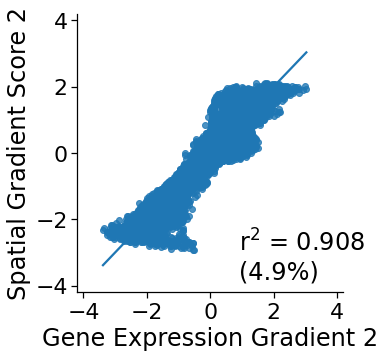

r2 = 0.9077158138009139, percent of total = 0.04874705054539814


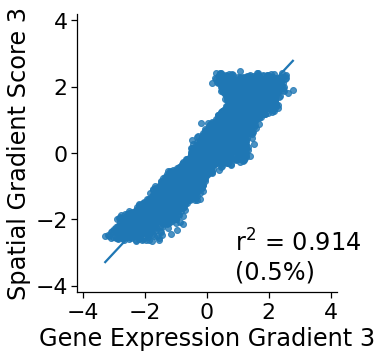

r2 = 0.9136361283386006, percent of total = 0.004527922591809246


In [30]:
pls_mod = PLSRegression(n_components=3)
pls_mod.fit(tr,tr_y)

# plot component scores
sns.set_context('notebook',font_scale=2)
total = 1
leftover = 1
for i in range(pls_mod.n_components):
    r2 = stats.pearsonr(pls_mod.x_scores_[:,i], pls_mod.y_scores_[:,i])[0]**2
    explained = (leftover * r2)
    exp_perc = explained * 100
    plt.close()
    plotr = pandas.concat([pandas.Series(pls_mod.x_scores_[:,i]),
                          pandas.Series(pls_mod.y_scores_[:,i])],
                         axis=1)
    plotr.columns = ['x','y']
    g=sns.lmplot(x='x', y='y',data=plotr)
    plt.xlim(-4.2,4.2)
    plt.ylim(-4.2,4.2)
    g.set(xticks=[-4,-2,0,2,4])
    plt.xlabel('Gene Expression Gradient %i'%(i+1))
    plt.ylabel('Spatial Gradient Score %i'%(i+1))
    plt.text(.9,-3.8,'r$^2$ = %s \n(%s%%)'%(round(r2,3),round(exp_perc,1)))
#     plt.savefig('/Users/jacobv/Science/PLS_GXP/txfer/ManuFigs/principal_correlation_%s.pdf'%i,
#                bbox_inches='tight')
    plt.show()
    print('r2 = %s, percent of total = %s'%(r2, explained))
    leftover -= explained


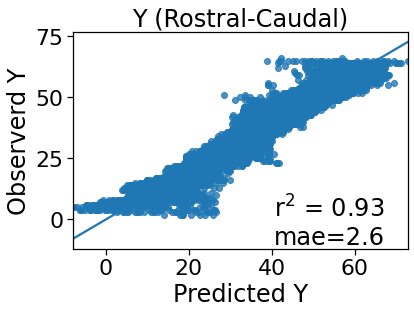

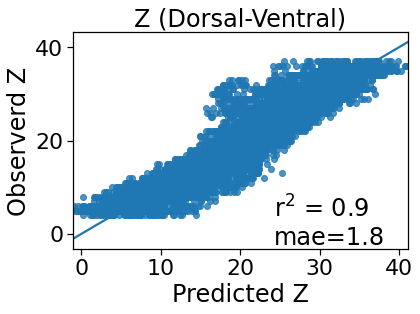

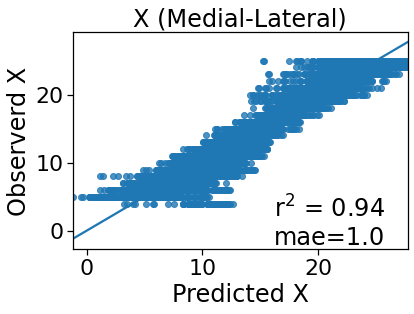

In [31]:
# plot model fit
pred = pls_mod.predict(tr)
labs = dict(zip(['Y','Z','X'],
                ['Rostral-Caudal',
                  'Dorsal-Ventral',
                  'Medial-Lateral']))

for i in range(tr_y.shape[-1]):
    fig = plt.figure(figsize=(6,4))
    ax = fig.add_subplot(111)
    label = tr_y.columns[i][-1].upper()
    sns.regplot(x=pred[:,i], y=tr_y[tr_y.columns[i]],
                #color = colos[label]
               )
    plt.title('%s (%s)'%(label,labs[label]))
    plt.xlabel('Predicted %s'%label)
    plt.ylabel('Observerd %s'%label)
    
#     tx = np.max(pred[:,i]) - np.min(pred[:,i]) * .4
#     tx = np.min(pred[:,i]) + tx
#     ty = np.max(tr_y[tr_y.columns[i]]
#                ) -np.min(tr_y[tr_y.columns[i]]) * -.5
#     ty = np.min(tr_y[tr_y.columns[i]]) + ty
    r2 = stats.pearsonr(pred[:,i], tr_y[tr_y.columns[i]])[0]**2
    mae = mean_absolute_error(pred[:,i], tr_y[tr_y.columns[i]])
    plt.text(0.6,0.02,
             'r$^2$ = %s \nmae=%s'%(round(r2,2),round(mae,1)),
            transform=ax.transAxes)
#     plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/Figs/TestRes_%s.pdf'%label,
#                bbox_inches='tight')
    plt.show()


In [105]:
preds_df.shape

(18033, 7)

In [57]:
set(preds_df.index) - set(vdf.index)

set()

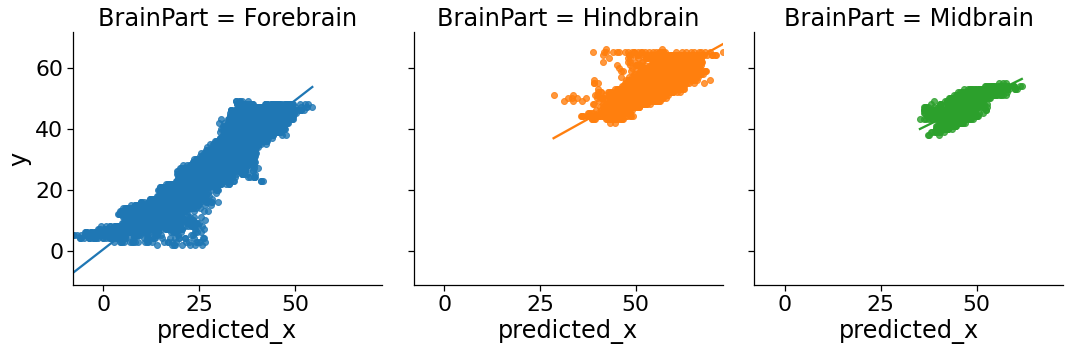

Forebrain r2 =0.8718824465734787
Forebrain mae =2.533661545446417
Hindbrain r2 =0.587971716774129
Hindbrain mae =2.7725187756207013
Midbrain r2 =0.5489137157946058
Midbrain mae =2.320339636239874


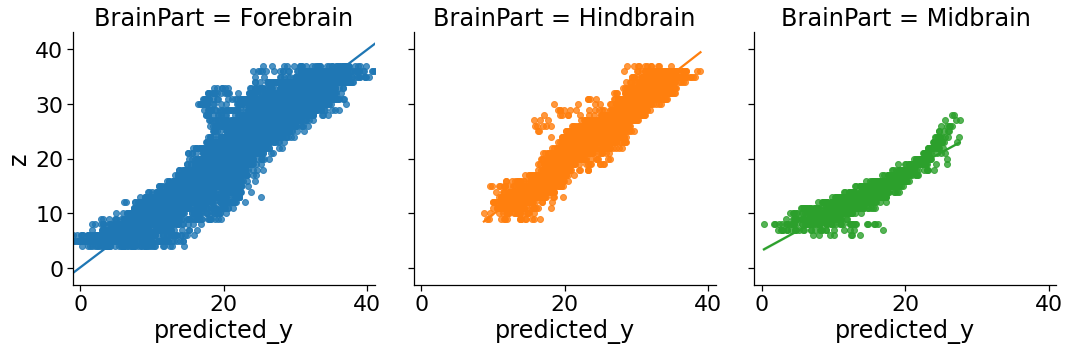

Forebrain r2 =0.889489187497242
Forebrain mae =1.911658936239434
Hindbrain r2 =0.9028804366670986
Hindbrain mae =1.4961346210233393
Midbrain r2 =0.8411405321557276
Midbrain mae =2.015867131774565


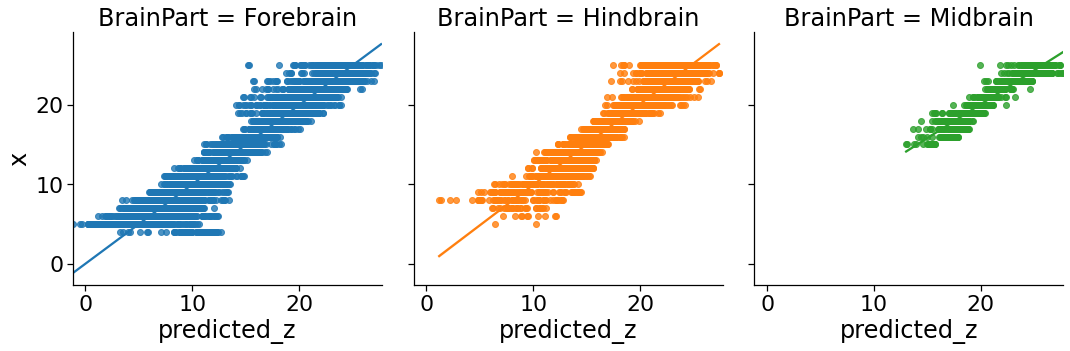

Forebrain r2 =0.941571042372978
Forebrain mae =0.9527068796754135
Hindbrain r2 =0.893571404423095
Hindbrain mae =1.1331220096251013
Midbrain r2 =0.8876181030828048
Midbrain mae =0.7952677371237864


In [32]:
# plot fit by slab type
preds_df = pandas.concat([pandas.DataFrame(pred, index=tr_y.index), tr_y],axis=1)
preds_df.columns = ['predicted_x', 'predicted_y','predicted_z'] + tr_y.columns.tolist()
preds_df.loc[:,'BrainPart'] = vdf.loc[preds_df.index].BrainPart.values
n_components = tr_y.shape[-1]
for i in range(n_components):
    plt.close()
    sns.lmplot(x=preds_df.columns[i], y = preds_df.columns[i+n_components], 
               col = 'BrainPart', data = preds_df,hue='BrainPart')
    #plt.title(preds_df.columns[i+n_components])
    plt.show()
    for slab in preds_df.BrainPart.unique():
        if not pandas.notnull(slab):
            continue
        r2 = stats.pearsonr(preds_df[preds_df.BrainPart==slab][preds_df.columns[i]],
                           preds_df[preds_df.BrainPart==slab][preds_df.columns[i+n_components]]
                           )[0]**2
        mae = mean_absolute_error(preds_df[preds_df.BrainPart==slab
                                          ][preds_df.columns[i]],
                                  preds_df[preds_df.BrainPart==slab
                                          ][preds_df.columns[i+n_components]])
        print('%s r2 =%s'%(slab,r2))
        print('%s mae =%s'%(slab,mae))

In [33]:
jnk = pandas.DataFrame(coords,copy=True)
jnk.loc[:,'BrainPart'] = vdf.BrainPart.values

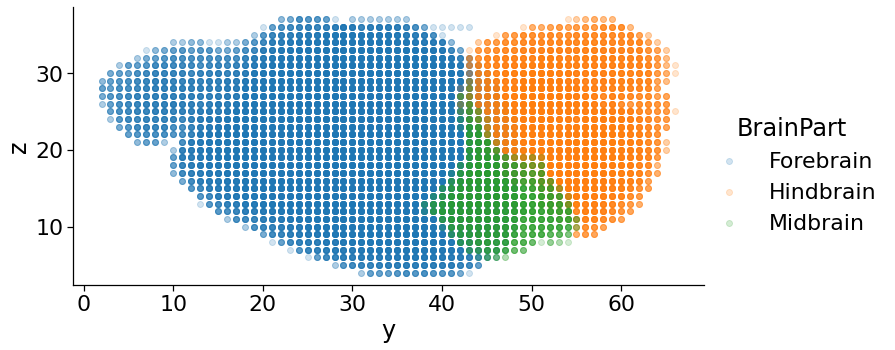

In [34]:
sns.lmplot(x='y',y='z',data=jnk,fit_reg=False,hue='BrainPart',aspect=2,
          scatter_kws={'alpha':0.2}#{'s':5}
          )

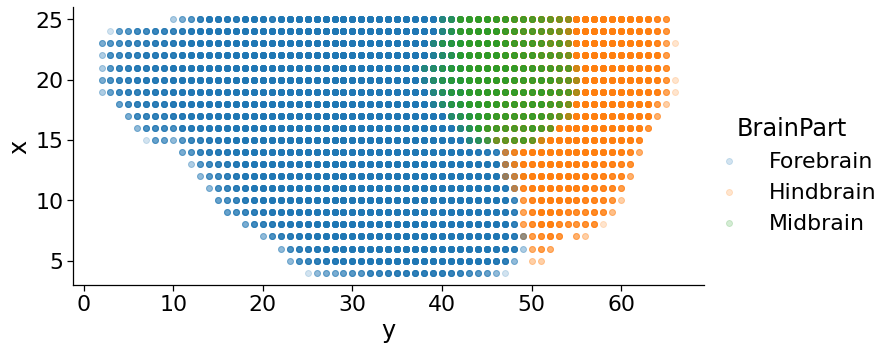

In [35]:
sns.lmplot(x='y',y='x',data=jnk,fit_reg=False,hue='BrainPart',aspect=2,
          scatter_kws={'alpha':0.2}#{'s':5}
          )

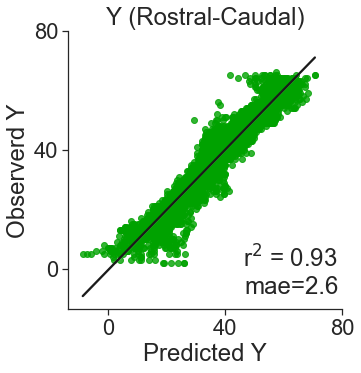

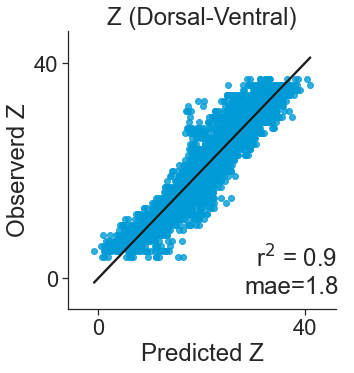

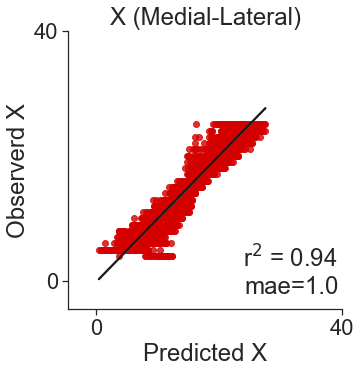

In [113]:
pal=sns.color_palette('nipy_spectral',n_colors=12)
colos = dict(zip(['Y','Z','X'],
                [pal[5],pal[3],pal[-1]]
                ))
# pal

# plot model fit
dims = ['Y','Z','X']
labs = dict(zip(dims,['Rostral-Caudal',
                      'Dorsal-Ventral',
                      'Medial-Lateral']))
te_pred = pls_mod.predict(te)
for i in range(te_y.shape[-1]):
#     fig = plt.figure(figsize=(6,4))
#     ax = fig.add_subplot(111)
    label = te_y.columns[i][-1].upper()
    plotr = pandas.concat([pandas.Series(te_pred[:,i]),
                          pandas.Series(te_y[te_y.columns[i]].values)],
                         axis=1)
    plotr.columns = ['x','y']
    g=sns.lmplot(x='x', y='y',data=plotr,
                 scatter_kws={'color':colos[label]},
                 line_kws={'color':'k'}
                )
    pmax = np.max(plotr.max().values)
    pmin = np.min(plotr.min().values)
    incr = 40
    tmin = int(round((pmin/incr))*incr)
    tmax = int(round((pmax/incr))*incr) + 1
    trange = list(range(tmin,tmax,incr))
    plt.title('%s (%s)'%(label,labs[label]))
    plt.xlabel('Predicted %s'%label)
    plt.ylabel('Observerd %s'%label)
    plt.xlim(pmin-5,pmax+5)
    plt.ylim(pmin-5,pmax+5)
    g.set(xticks=trange,yticks=trange)
    r2 = stats.pearsonr(te_pred[:,i], te_y[te_y.columns[i]])[0]**2
    mae = mean_absolute_error(te_pred[:,i], te_y[te_y.columns[i]])
    plt.text(0.85,0.2,
             'r$^2$ = %s \nmae=%s'%(round(r2,2),round(mae,1)),
            transform=ax.transAxes,horizontalalignment='right')
#     plt.savefig('/Users/jacobv/Science/PLS_GXP/txfer/ManuFigs/TestRes_%s.pdf'%label,
#                bbox_inches='tight')
    plt.show()


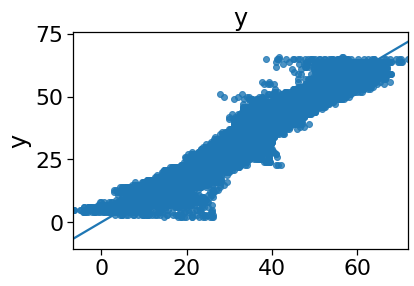

(0.9670014457624688, 0.0)
2.567140536655507


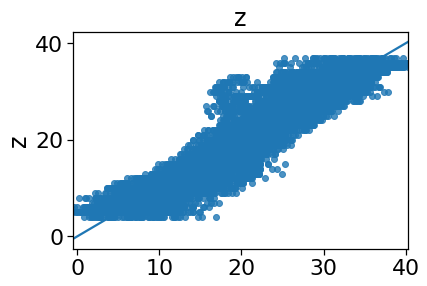

(0.94776822982859, 0.0)
1.8091027679814422


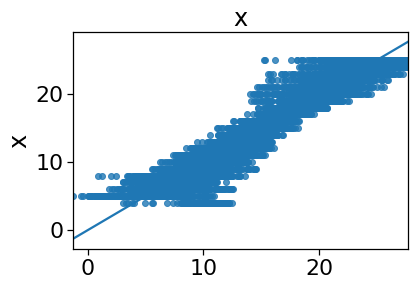

(0.968390768209693, 0.0)
0.9740004472948082


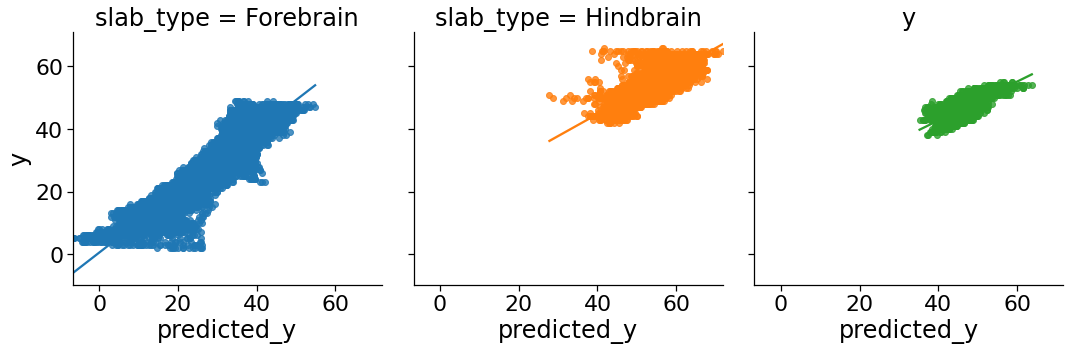

Forebrain r2 =0.8730089264714885
Forebrain mae =15.67524519433973
Hindbrain r2 =0.5700898027091355
Hindbrain mae =35.52103422099261
Midbrain r2 =0.5875433342983437
Midbrain mae =25.48556559284173


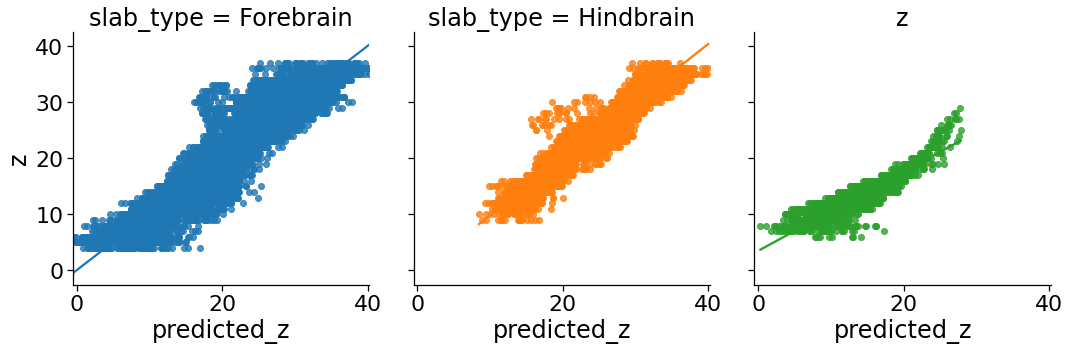

Forebrain r2 =0.8904536311447019
Forebrain mae =12.849480829679127
Hindbrain r2 =0.9052953247776582
Hindbrain mae =30.4940387995905
Midbrain r2 =0.8279866073353176
Midbrain mae =31.877130216650894


Forebrain r2 =0.9424993691498056
Forebrain mae =9.07720888015488
Hindbrain r2 =0.8968216345699703
Hindbrain mae =7.504836256107795
Midbrain r2 =0.8922070283163458
Midbrain mae =7.330761746525268


In [36]:
pls_mod = PLSRegression(n_components=3)
full_y = coords
pls_mod.fit(pca_tfm, full_y)
# plot model fit
pred = pls_mod.predict(pca_tfm)
for i in range(full_y.shape[-1]):
    plt.close()
    sns.regplot(x=pred[:,i], y=full_y[full_y.columns[i]])
    plt.title(full_y.columns[i])
    plt.show()
    print(stats.pearsonr(pred[:,i], full_y[full_y.columns[i]]))
    print(mean_absolute_error(pred[:,i], full_y[full_y.columns[i]]))
# plot fit by slab type
preds_df = pandas.concat([pandas.DataFrame(pred, index=full_y.index), full_y],axis=1)
preds_df.columns = ['predicted_y', 'predicted_z', 'predicted_x'] + full_y.columns.tolist()
preds_df.loc[:,'slab_type'] = vdf.loc[pca_tfm.index,'BrainPart']
n_components = full_y.shape[-1]
for i in range(n_components):
    plt.close()
    sns.lmplot(x=preds_df.columns[i], y = preds_df.columns[i+n_components], 
               col = 'slab_type', data = preds_df, hue='slab_type')
    plt.title(preds_df.columns[i+n_components])
    plt.show()
    for slab in preds_df.slab_type.unique():
        r2 = stats.pearsonr(preds_df[preds_df.slab_type==slab][preds_df.columns[i]],
                           preds_df[preds_df.slab_type==slab][preds_df.columns[i+n_components]]
                           )[0]**2
        mae = mean_absolute_error(preds_df[preds_df.slab_type==slab
                                          ][preds_df.columns[i]],
                                  preds_df[preds_df.slab_type==slab
                                          ][preds_df.columns[i+2]])
        print('%s r2 =%s'%(slab,r2))
        print('%s mae =%s'%(slab,mae))

/Users/jacobv/jakepy/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(24.025701041666665, 0.5, 'Z')

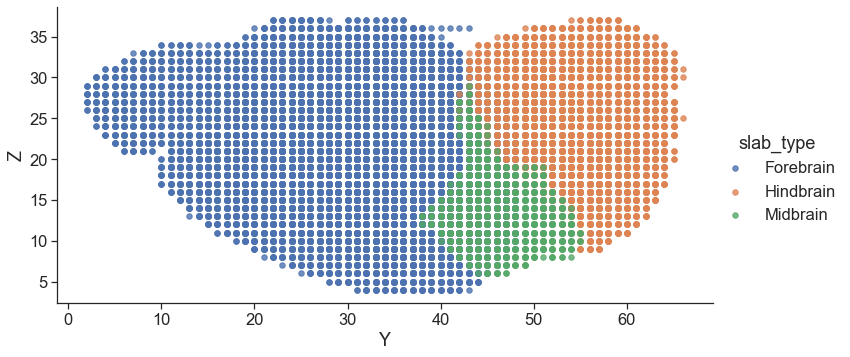

In [120]:
sns.set_context('notebook',font_scale=1.5)
sns.lmplot('y', 'z', hue = 'slab_type', data=preds_df, fit_reg=False, 
           scatter_kws={"s": 30},aspect=2)
plt.xlabel('Y')
plt.ylabel('Z')
#plt.ylim(-85,90)
#plt.xlim(-115,75)
# plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ManuFigs/brain_plot_YZ.pdf',
#            bbox_inches='tight')

In [121]:
sns.lmplot(x='predicted_y', y='predicted_z', hue = 'slab_type', 
           data=preds_df, aspect=2,
           fit_reg=False, scatter_kws={"s": 30})
plt.xlabel('Predicted Y')
plt.ylabel('Predicted Z')
# plt.ylim(-85,90)
# plt.xlim(-115,75)
# plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ManuFigs/brain_plot_YZ_pred.pdf',
#            bbox_inches='tight')

Text(24.025701041666665, 0.5, 'Predicted Z')

In [38]:
pls_mod = PLSRegression(n_components=3)
pls_mod.fit(pca_tfm, full_y)
bsrx, bsry, allx_bs, ally_bs = xd.bootstrap_features(PLSRegression(n_components=3), 
                                                  pls_mod, 
                                                  pca_tfm, 
                                                  full_y, 
                                                  n_iterations=1000)

finished iteration 0
finished iteration 100


/Users/jacobv/jakepy/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:77: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


finished iteration 200
finished iteration 300
finished iteration 400


/Users/jacobv/jakepy/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:77: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


finished iteration 500


/Users/jacobv/jakepy/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:77: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
/Users/jacobv/jakepy/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:77: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


finished iteration 600


/Users/jacobv/jakepy/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:77: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


finished iteration 700


/Users/jacobv/jakepy/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:77: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


finished iteration 800
finished iteration 900


In [58]:
sns.set_context('notebook',font_scale=2)
g = pandas.DataFrame(pls_mod.y_weights_, 
                 index=['y','z','x'],
                 columns=['component %s'%x for x in range(3)]).T.plot.bar()
g.set_xticklabels(['C1','C2','C3'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

ImportError: matplotlib is required for plotting when the default backend "matplotlib" is selected.

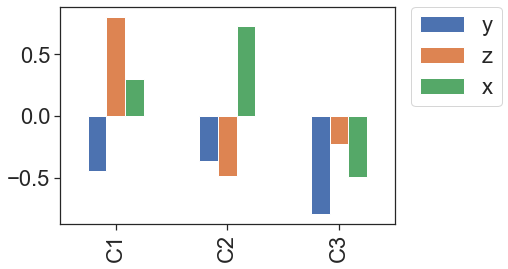

In [152]:
sns.set_context('notebook',font_scale=2)
g = pandas.DataFrame(pls_mod.y_weights_.T, 
                 index=['y','z','x'],
                 columns=['component %s'%x for x in range(3)]).T.plot.bar()
g.set_xticklabels(['C1','C2','C3'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [59]:
plotr = pandas.concat([pandas.Series(allx_bs[0].values.flatten()),
                       #pandas.Series(list(range(100))*500)],
                       pandas.Series(list(range(100))*1000)],
                      axis=1)
plotr.columns = ['Loading','Component']

[Text(0, 0, ''),
 Text(1, 0, ''),
 Text(2, 0, ''),
 Text(3, 0, ''),
 Text(4, 0, ''),
 Text(5, 0, ''),
 Text(6, 0, ''),
 Text(7, 0, ''),
 Text(8, 0, ''),
 Text(9, 0, ''),
 Text(10, 0, ''),
 Text(11, 0, ''),
 Text(12, 0, ''),
 Text(13, 0, ''),
 Text(14, 0, ''),
 Text(15, 0, ''),
 Text(16, 0, ''),
 Text(17, 0, ''),
 Text(18, 0, ''),
 Text(19, 0, ''),
 Text(20, 0, ''),
 Text(21, 0, ''),
 Text(22, 0, ''),
 Text(23, 0, ''),
 Text(24, 0, ''),
 Text(25, 0, ''),
 Text(26, 0, ''),
 Text(27, 0, ''),
 Text(28, 0, ''),
 Text(29, 0, ''),
 Text(30, 0, ''),
 Text(31, 0, ''),
 Text(32, 0, ''),
 Text(33, 0, ''),
 Text(34, 0, ''),
 Text(35, 0, ''),
 Text(36, 0, ''),
 Text(37, 0, ''),
 Text(38, 0, ''),
 Text(39, 0, ''),
 Text(40, 0, ''),
 Text(41, 0, ''),
 Text(42, 0, ''),
 Text(43, 0, ''),
 Text(44, 0, ''),
 Text(45, 0, ''),
 Text(46, 0, ''),
 Text(47, 0, ''),
 Text(48, 0, ''),
 Text(49, 0, ''),
 Text(50, 0, ''),
 Text(51, 0, ''),
 Text(52, 0, ''),
 Text(53, 0, ''),
 Text(54, 0, ''),
 Text(55, 0, ''),
 T

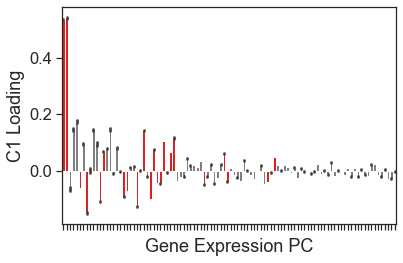

In [127]:
sns.set(font_scale=1.5)
sns.set_style('ticks')
colors = ['Red' if x else 'Grey' for x in multipletests(bsrx['p'].loc[0], method='fdr_bh')[0]]
g=sns.barplot(x='Component', y='Loading', data=plotr, palette=colors)
plt.xlabel('Gene Expression PC')
plt.ylabel('C1 Loading')
g.set_xticklabels([None for x in range(100)])
# plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ManuFigs/C1_XWeights.pdf',
#             bbox_inches='tight')

In [60]:
sigs = multipletests(bsrx['p'].loc[0], method='fdr_bh')[0]
new_loading = [pls_mod.x_loadings_[x,0] if sigs[x] else 0 for x in range(pca_tfm.shape[-1])]
newc1 = np.dot(pcamod.components_.T, new_loading)
newc1 = pandas.concat([pandas.Series(newc1), pandas.Series(iexp.index)],
                      axis=1)

In [61]:
newc1.loc[:,'acronym'] = gdf.acronym.values

In [151]:
newc1.sort_values(newc1.columns[0])

0     1  acronym
145  -0.097781   145    Aplp1
1043 -0.086235  1043     Plp1
84   -0.079052    84     Ache
612  -0.069517   612     Hap1
1150 -0.067280  1150     Scg2
...        ...   ...      ...
953   0.111159   953      Nov
709   0.115728   709    Icam5
853   0.116126   853    Mef2c
1852  0.118234  1852     Nrgn
1971  0.123420  1971  Slc17a7

[2069 rows x 3 columns]

In [153]:
newc1.to_csv('/Users/jacobv/Science/PLS_GXP/Mouse/GCORR_C1_genelist.csv')

In [155]:
plotr = pandas.concat([pandas.Series(allx_bs[1].values.flatten()),
                       pandas.Series(list(range(100))*1000)],
                      axis=1)
plotr.columns = ['Loading','Component']
colors = ['Red' if x < 0.05 else 'Grey' for x in bsrx['p'].loc[1]]
sns.barplot(x='Component', y='Loading', data=plotr, palette=colors)
plt.xlabel('Gene Expression PC')
plt.ylabel('C2 Loading')
#g.set_xticklabels([None for x in range(100)])
# plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ManuFigs/C2_XWeights.pdf',
#             bbox_inches='tight')

Text(0, 0.5, 'C2 Loading')

In [62]:
sigs = multipletests(bsrx['p'].loc[1], method='fdr_bh')[0]
new_loading = [pls_mod.x_loadings_[x,1] if sigs[x] else 0 for x in range(pca_tfm.shape[-1])]
newc2 = np.dot(pcamod.components_.T, new_loading)
newc2 = pandas.concat([pandas.Series(newc2), pandas.Series(iexp.index)],
                      axis=1)
newc2.loc[:,'acronym'] = gdf.acronym.values

In [160]:
newc2.sort_values(0)

0     1 acronym
1930 -0.113841  1930   Rab3b
1278 -0.106791  1278    Syt1
405  -0.105480   405    Egr3
709  -0.101320   709   Icam5
877  -0.100193   877   Meis2
...        ...   ...     ...
1869  0.079479  1869  Clstn1
1185  0.080901  1185    Scg5
1098  0.088451  1098   Pvalb
1994  0.100070  1994    Cds1
523   0.103035   523  Gabra1

[2069 rows x 3 columns]

In [161]:
newc2.to_csv('/Users/jacobv/Science/PLS_GXP/Mouse/GCORR_C2_genelist.csv')

Text(0, 0.5, 'C2 Loading')

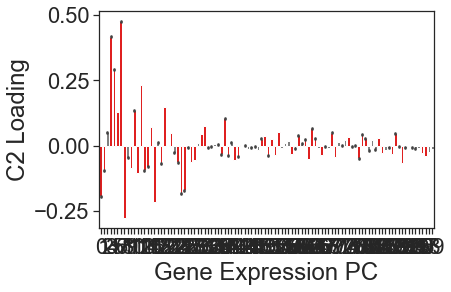

In [163]:
plotr = pandas.concat([pandas.Series(allx_bs[2].values.flatten()),
                       pandas.Series(list(range(100))*1000)],
                      axis=1)
plotr.columns = ['Loading','Component']
colors = ['Red' if x < 0.05 else 'Grey' for x in bsrx['p'].loc[2]]
sns.barplot(x='Component', y='Loading', data=plotr, palette=colors)
plt.xlabel('Gene Expression PC')
plt.ylabel('C2 Loading')
#g.set_xticklabels([None for x in range(100)])
# plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ManuFigs/C2_XWeights.pdf',
#             bbox_inches='tight')

In [63]:
sigs = multipletests(bsrx['p'].loc[2], method='fdr_bh')[0]
new_loading = [pls_mod.x_loadings_[x,2] if sigs[x] else 0 for x in range(pca_tfm.shape[-1])]
newc3 = np.dot(pcamod.components_.T, new_loading)
newc3 = pandas.concat([pandas.Series(newc3), pandas.Series(iexp.index)],
                      axis=1)
newc3.loc[:,'acronym'] = gdf.acronym.values
newc3.sort_values(0)

0     1  acronym
47   -0.142128    47   Jmjd1c
853  -0.135671   853    Mef2c
1015 -0.132858  1015    Pcsk2
1525 -0.113218  1525      Ntm
802  -0.109702   802     Lmo4
...        ...   ...      ...
1283  0.081080  1283   Churc1
1367  0.086492  1367  Tsc22d1
149   0.105885   149      App
1869  0.121521  1869   Clstn1
1939  0.148246  1939   Pgrmc2

[2069 rows x 3 columns]

In [166]:
newc3.to_csv('/Users/jacobv/Science/PLS_GXP/Mouse/GCORR_C3_genelist.csv')

In [64]:
gdf.loc[:,'C1'] = newc1.loc[:,0].values
gdf.loc[:,'C2'] = newc2.loc[:,0].values
gdf.loc[:,'C3'] = newc3.loc[:,0].values

#### Projection

In [172]:
# pcamod = PCA(n_components=100, random_state=123).fit(bigdf)
# sum(pcamod.explained_variance_ratio_)
#pca_tfm = pandas.DataFrame(pcamod.transform(bigdf))
pls_mod = PLSRegression(n_components=3)
#full_y = gdf[['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']]
pls_mod.fit(pca_tfm, full_y)

PLSRegression(n_components=3)

In [71]:
vdf.loc[:,['y','z','x']] = coords.values

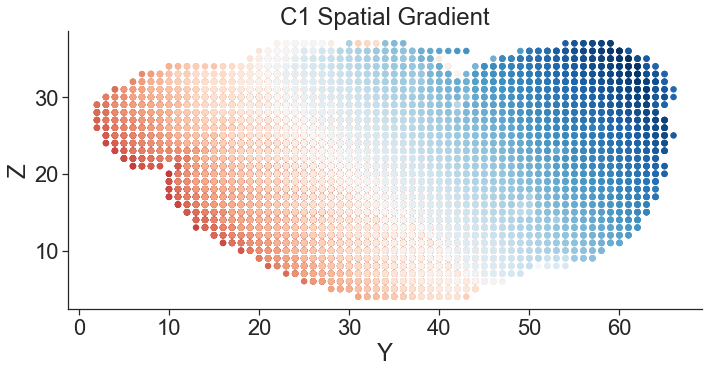

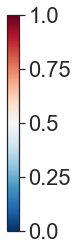

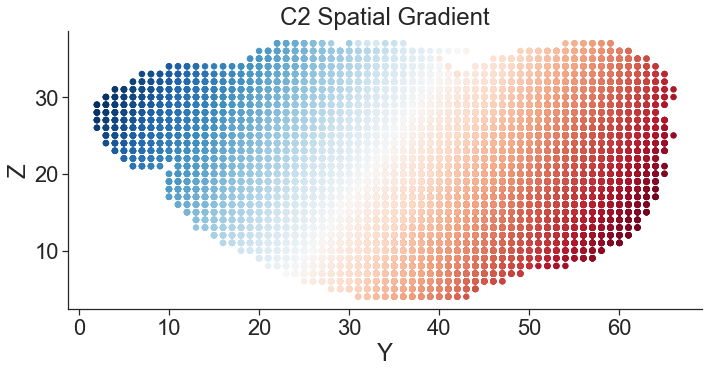

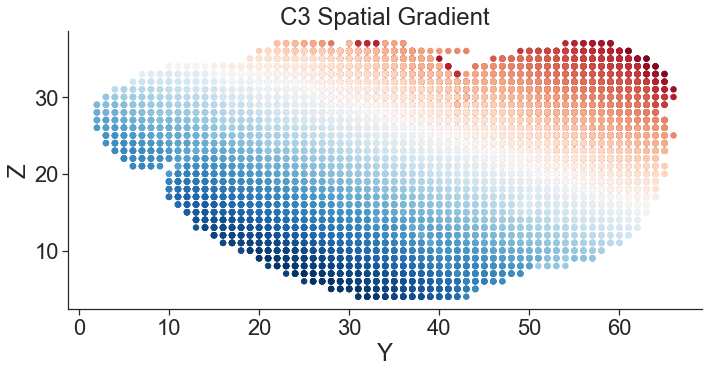

In [183]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.colors import Normalize

cmap = sns.color_palette('RdBu_r',as_cmap=True)

for i in range(pls_mod.y_weights_.shape[0]):
    #sg = np.dot(full_y.values,pls_mod.y_weights_[i,:])
    sg = np.dot(full_y.values,pls_mod.y_weights_[:,i])
    scaled_sg = MinMaxScaler().fit_transform(sg.reshape(-1,1))[:,0]
    vdf.loc[:,'C%s_SmoothGradient'%(i+1)] = sg
    norm = Normalize(vmin=np.min(scaled_sg), 
                                       vmax=np.max(scaled_sg))
    cscale = cmap(norm(scaled_sg))

    g = sns.lmplot(x='y', y='z',  
                   data=vdf, fit_reg=False, aspect=2,
                   scatter_kws={"s": 30,'color':cscale},
                  palette='RdBu_r')
    
    plt.xlabel('Y')
    plt.ylabel('Z')
    plt.title('C%s Spatial Gradient'%(i+1))
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#     plt.ylim(-85,90)
#     plt.xlim(-115,75)
#     plt.xticks([-100,-50,0,50])
#     plt.yticks(list(range(-75,76,25)))
#     plt.savefig('/Users/jacobv/Science/PLS_GXP/txfer/ManuFigs/brain_plot_SpatialC%s_YZ.pdf'%(i+1),
#                bbox_inches='tight')

    if i == 0:
    # colorbar
        a = np.array([[0,1]])
        #a = np.linspace(0,1,10)
        plt.figure(figsize=(.2, 5))
        img = plt.imshow(a, cmap="RdBu_r")
        plt.gca().set_visible(False)
        cax = plt.axes([0.1, 0.2, 0.8, 0.6])
        cbar = plt.colorbar(orientation="vertical", cax=cax)
        #newticks = [int(round(norm.inverse(x))) for x in cbar.get_ticks()]
        newticks = [norm.inverse(x) for x in cbar.get_ticks()]
        cbar.set_ticks(cbar.get_ticks())
        cbar.set_ticklabels(newticks)
#         plt.savefig('/Users/jacobv/Science/PLS_GXP/txfer/ManuFigs/brain_plot_component_cbar.pdf',
#                    bbox_inches='tight')

        plt.show()




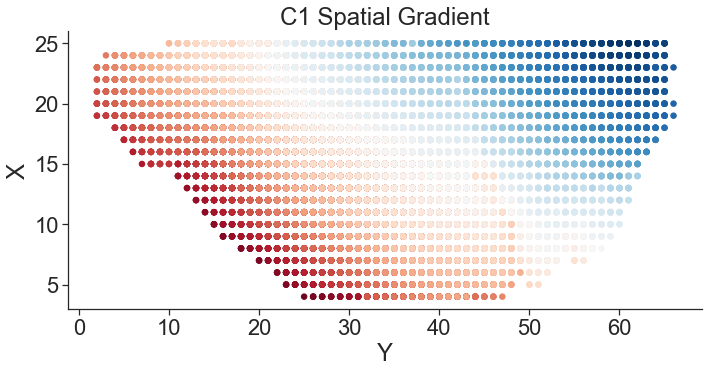

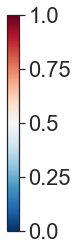

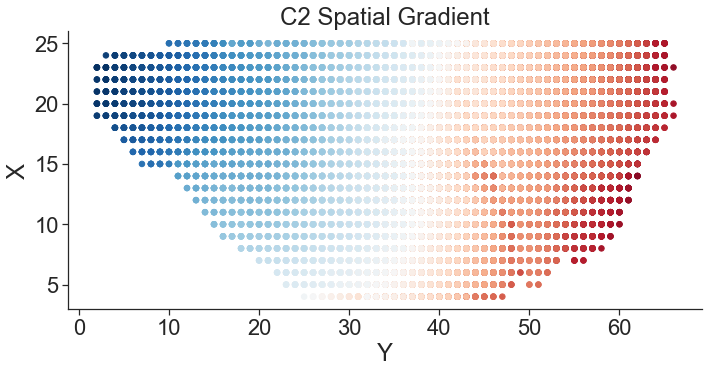

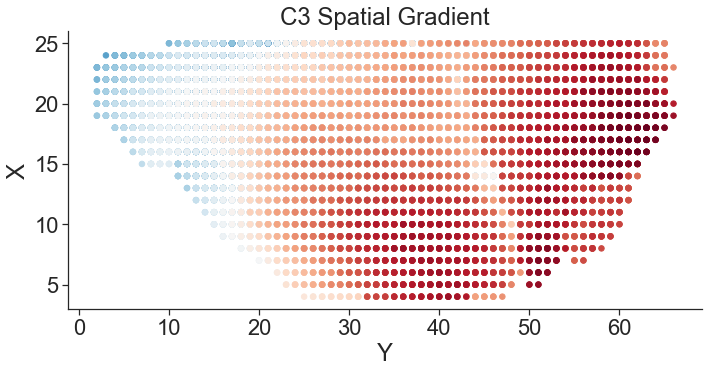

In [184]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.colors import Normalize

cmap = sns.color_palette('RdBu_r',as_cmap=True)

for i in range(pls_mod.y_weights_.shape[0]):
    #sg = np.dot(full_y.values,pls_mod.y_weights_[i,:])
    sg = np.dot(full_y.values,pls_mod.y_weights_[:,i])
    scaled_sg = MinMaxScaler().fit_transform(sg.reshape(-1,1))[:,0]
    vdf.loc[:,'C%s_SmoothGradient'%(i+1)] = sg
    norm = Normalize(vmin=np.min(scaled_sg), 
                                       vmax=np.max(scaled_sg))
    cscale = cmap(norm(scaled_sg))

    g = sns.lmplot(x='y', y='x',  
                   data=vdf, fit_reg=False, aspect=2,
                   scatter_kws={"s": 30,'color':cscale},
                  palette='RdBu_r')
    
    plt.xlabel('Y')
    plt.ylabel('X')
    plt.title('C%s Spatial Gradient'%(i+1))
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#     plt.ylim(-85,90)
#     plt.xlim(-115,75)
#     plt.xticks([-100,-50,0,50])
#     plt.yticks(list(range(-75,76,25)))
#     plt.savefig('/Users/jacobv/Science/PLS_GXP/txfer/ManuFigs/brain_plot_SpatialC%s_YZ.pdf'%(i+1),
#                bbox_inches='tight')

    if i == 0:
    # colorbar
        a = np.array([[0,1]])
        #a = np.linspace(0,1,10)
        plt.figure(figsize=(.2, 5))
        img = plt.imshow(a, cmap="RdBu_r")
        plt.gca().set_visible(False)
        cax = plt.axes([0.1, 0.2, 0.8, 0.6])
        cbar = plt.colorbar(orientation="vertical", cax=cax)
        #newticks = [int(round(norm.inverse(x))) for x in cbar.get_ticks()]
        newticks = [norm.inverse(x) for x in cbar.get_ticks()]
        cbar.set_ticks(cbar.get_ticks())
        cbar.set_ticklabels(newticks)
#         plt.savefig('/Users/jacobv/Science/PLS_GXP/txfer/ManuFigs/brain_plot_component_cbar.pdf',
#                    bbox_inches='tight')

        plt.show()




In [ ]:
pls_mod.x

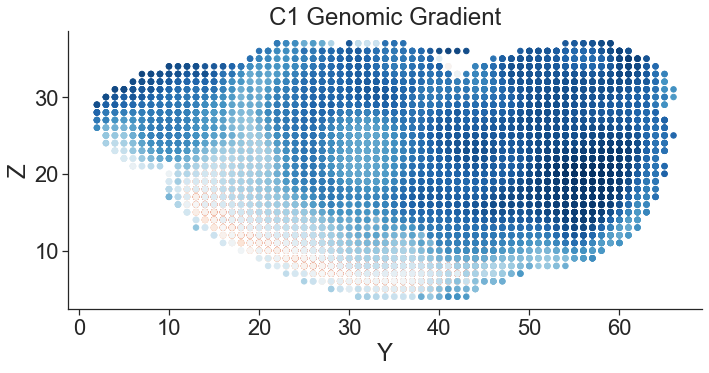

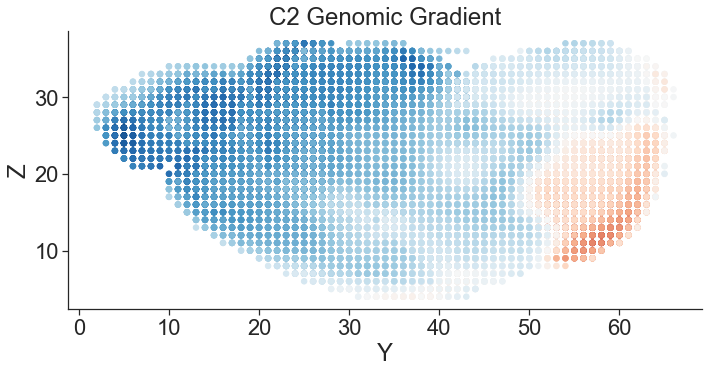

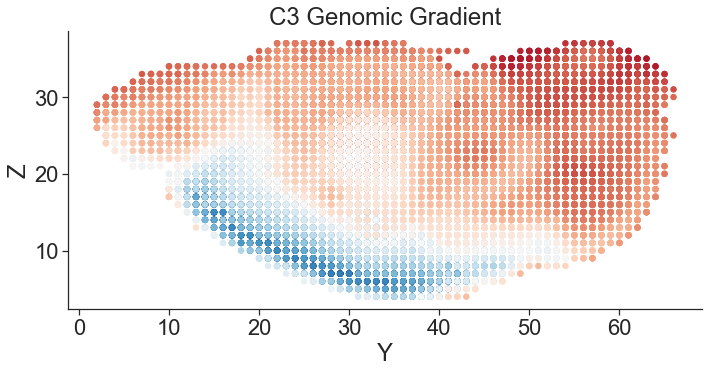

In [186]:
from sklearn.preprocessing import MinMaxScaler

cmap = sns.color_palette('RdBu_r',as_cmap=True)

for i in range(pls_mod.y_weights_.shape[0]):
    #if i == 2:
    sg = np.dot(pca_tfm.values,pls_mod.x_weights_[:,i])
    #else:
    #    sg = -gdf.loc[:,'Component%s_Expresion'%(i+1)].values
    scaled_sg = MinMaxScaler().fit_transform(sg.reshape(-1,1))[:,0]
    norm = Normalize(vmin=np.min(scaled_sg), 
                                       vmax=np.max(scaled_sg))
    cscale = cmap(norm(scaled_sg))

    g = sns.lmplot(x='y', y='z', aspect=2, 
                   data=vdf, fit_reg=False, 
                   scatter_kws={"s": 30,'color':cscale},
                  palette='RdBu_r')
    
    plt.xlabel('Y')
    plt.ylabel('Z')
    plt.title('C%s Genomic Gradient'%(i+1))
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#     plt.ylim(-85,90)
#     plt.xlim(-115,75)
#     plt.xticks([-100,-50,0,50])
#     plt.yticks(list(range(-75,76,25)))
#     plt.savefig('/Users/jacobv/Science/PLS_GXP/txfer/ManuFigs/brain_plot_GenomicC%s_YZ.pdf'%(i+1),
#                bbox_inches='tight')



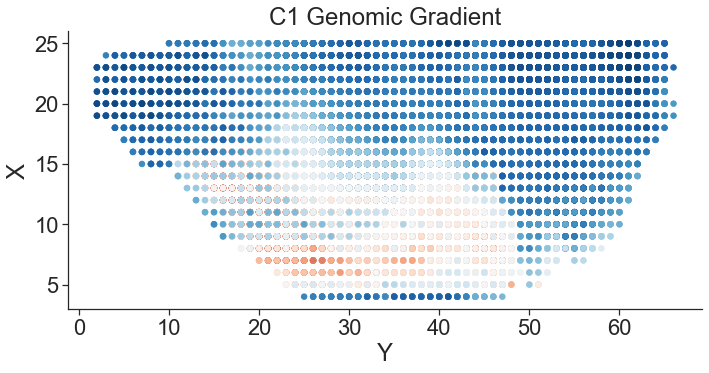

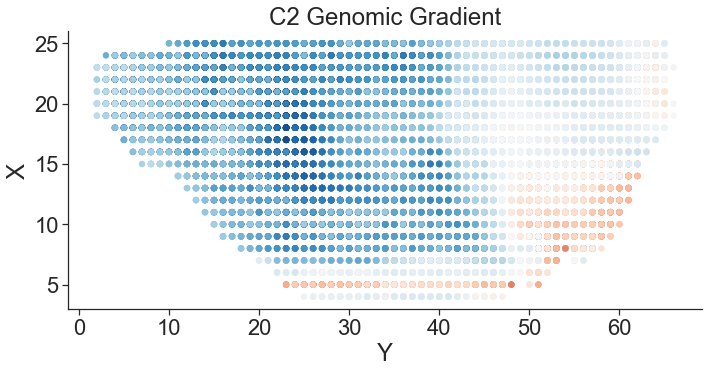

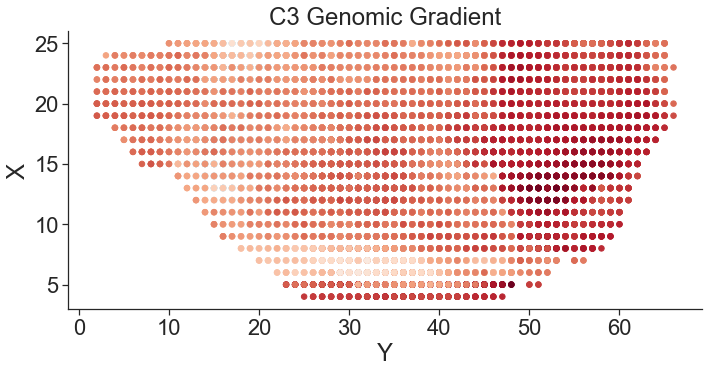

In [187]:
from sklearn.preprocessing import MinMaxScaler

cmap = sns.color_palette('RdBu_r',as_cmap=True)

for i in range(pls_mod.y_weights_.shape[0]):
    #if i == 2:
    sg = np.dot(pca_tfm.values,pls_mod.x_weights_[:,i])
    #else:
    #    sg = -gdf.loc[:,'Component%s_Expresion'%(i+1)].values
    scaled_sg = MinMaxScaler().fit_transform(sg.reshape(-1,1))[:,0]
    norm = Normalize(vmin=np.min(scaled_sg), 
                                       vmax=np.max(scaled_sg))
    cscale = cmap(norm(scaled_sg))

    g = sns.lmplot(x='y', y='x', aspect=2, 
                   data=vdf, fit_reg=False, 
                   scatter_kws={"s": 30,'color':cscale},
                  palette='RdBu_r')
    
    plt.xlabel('Y')
    plt.ylabel('X')
    plt.title('C%s Genomic Gradient'%(i+1))
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#     plt.ylim(-85,90)
#     plt.xlim(-115,75)
#     plt.xticks([-100,-50,0,50])
#     plt.yticks(list(range(-75,76,25)))
#     plt.savefig('/Users/jacobv/Science/PLS_GXP/txfer/ManuFigs/brain_plot_GenomicC%s_YZ.pdf'%(i+1),
#                bbox_inches='tight')



# Homologging

In [192]:
len(gset['EntrezGene ID'].unique())

2038

In [52]:
gset = hlog[(hlog['Common Organism Name']=='mouse, laboratory') &\
            (hlog['EntrezGene ID'].isin(gdf.entrezID.values))]
gset.index = gset['EntrezGene ID'].values
shared = list(set(gdf.entrezID.values) & set(gset.index.values))
gdf.loc[:,'orig_id'] = gdf.index
gdf.index=gdf.entrezID.values


In [53]:
for i,row in gset.iterrows():
    hid = row['HomoloGene ID']
    eid = row['EntrezGene ID']
    match = hlog[(hlog['Common Organism Name']=='human') &\
            (hlog['HomoloGene ID']==hid)]
    if len(match==1):
        gdf.loc[eid,'human_symbol'] = match['Symbol'].values[0]
        gdf.loc[eid,'human_eid'] = match['EntrezGene ID'].values[0]
        gdf.loc[eid,'syns'] = match['Synonyms'].values[0]

In [54]:
human = pandas.read_csv('/Users/jacobv/Dropbox/Work/Projects/PLS_ABA/PLS_GXP_CollabSpace/PLS_Component_Expr.csv')
human.head()

gene_symbol                     gene_name   C1_expr   C2_expr   C3_expr
0        A1BG        alpha-1-B glycoprotein  0.001517  0.006065 -0.020001
1    A1BG-AS1                           NaN -0.006685 -0.006733 -0.002762
2         A2M         alpha-2-macroglobulin  0.005135  0.007225  0.002345
3       A2ML1  alpha-2-macroglobulin-like 1 -0.009261 -0.004295 -0.010945
4     A3GALT2                           NaN -0.001305 -0.000388 -0.000463

In [55]:
homogene = [x for x in gdf.human_symbol.values if x in human.gene_symbol.values]
human.loc[:,'orig_index'] = human.index
human.index = human.gene_symbol.values
gdf.index = gdf.human_symbol.values


In [65]:
jnka = gdf.loc[homogene,['C1','C2','C3']]
jnka.columns = ['MouseC1','MouseC2','MouseC3']
jnkb = human.loc[homogene,['C1_expr','C2_expr','C3_expr']]
jnkb.columns = ['HumanC1','HumanC2','HumanC3']
homocomp = pandas.concat([jnka,jnkb],axis=1)
homocomp.head()

MouseC1   MouseC2   MouseC3   HumanC1   HumanC2   HumanC3
NRG2     0.007030  0.012848  0.006192  0.006455 -0.002230  0.013806
CAMTA1   0.018132  0.026013  0.051316  0.006785 -0.009396 -0.003544
DCUN1D4  0.010149 -0.004752  0.001937  0.001091 -0.000446  0.004482
NFXL1    0.003327 -0.000658  0.003592  0.008827  0.009024  0.000342
CPNE7   -0.006572 -0.046767  0.018607 -0.009136  0.004629 -0.007924

<AxesSubplot:>

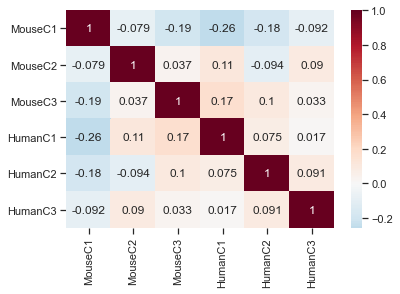

In [229]:
sns.set_context('notebook',font_scale=1)
cmat = pandas.DataFrame(np.corrcoef(homocomp.T),
                        index=homocomp.columns,
                        columns=homocomp.columns)
sns.heatmap(cmat,annot=True,center=0,cmap='RdBu_r')

In [232]:
homocomp.to_csv('/Users/jacobv/Science/PLS_GXP/Mouse/MouseHumanComp_Orig.csv')

In [41]:
homocomp = pandas.read_csv('/Users/jacobv/Science/PLS_GXP/Mouse/MouseHumanComp_Orig.csv',
                           index_col=0)

#### Same thing after redoing human PLS with only mouse genes

In [43]:
hg2 = pandas.read_csv('/Users/jacobv/Science/PLS_GXP/Mouse/HumanComps_mouseGenes.csv',
                     index_col=0)
hg2.index = hg2.gene_symbol.values
hg2.head()

gene_symbol                                          gene_name  \
NRG2           NRG2                                       neuregulin 2   
CAMTA1       CAMTA1       calmodulin binding transcription activator 1   
DCUN1D4     DCUN1D4  DCN1, defective in cullin neddylation 1, domai...   
NFXL1         NFXL1  nuclear transcription factor, X-box binding-li...   
CPNE7         CPNE7                                         copine VII   

               C1        C2        C3  
NRG2     0.019351 -0.013131  0.037018  
CAMTA1   0.006166 -0.026090 -0.013369  
DCUN1D4 -0.006462 -0.006269  0.015598  
NFXL1    0.021379  0.005243 -0.000481  
CPNE7   -0.035051  0.000959 -0.037282

In [44]:
for i in range(1,4):
    homocomp.loc[:,'HumanC%s'%i] = hg2.loc[homocomp.index,'C%s'%i].values

<AxesSubplot:>

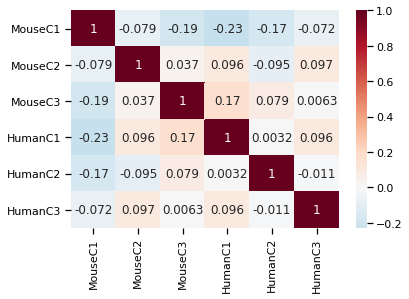

In [45]:
sns.set_context('notebook',font_scale=1)
cmat = pandas.DataFrame(np.corrcoef(homocomp.T),
                        index=homocomp.columns,
                        columns=homocomp.columns)
sns.heatmap(cmat,annot=True,center=0,cmap='RdBu_r')

r = -0.229, p = 0.0


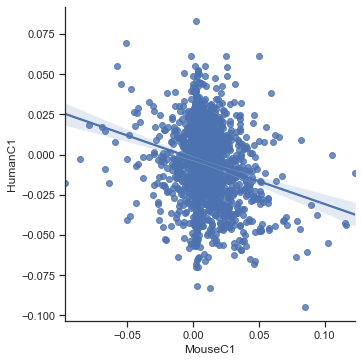

r = -0.173, p = 0.0


r = -0.072, p = 0.004


r = 0.096, p = 0.0


r = -0.095, p = 0.0


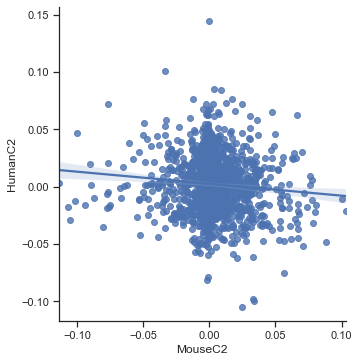

r = 0.097, p = 0.0


r = 0.166, p = 0.0


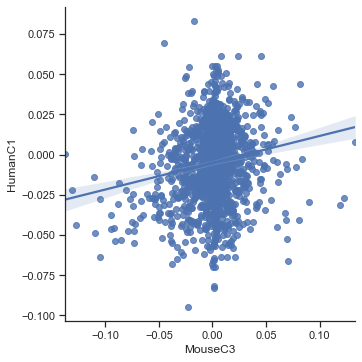

r = 0.079, p = 0.002


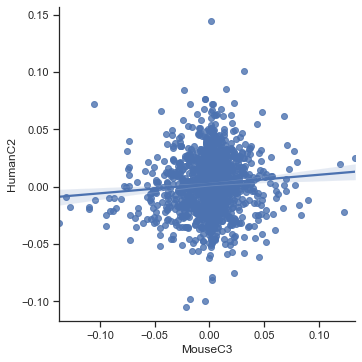

r = 0.006, p = 0.804


In [240]:
for i in range(1,4):
    for j in range(1,4):
        sns.lmplot(x='MouseC%s'%i,y='HumanC%s'%j,data=homocomp)
        r,p = stats.pearsonr(homocomp['MouseC%s'%i],
                            homocomp['HumanC%s'%j])
        print('r = %s, p = %s'%(round(r,3),round(p,3)))
        plt.show()

#### Mouse expression of human components

In [46]:
iexp.shape

(2069, 24044)

In [66]:
hexp = pandas.DataFrame(iexp,copy=True)
hexp.index = gdf.index
hexp = hexp.loc[homocomp.index]
hexp.shape

(1576, 24044)

In [248]:
np.dot(homocomp.HumanC1.values,hexp).shape

(24044,)

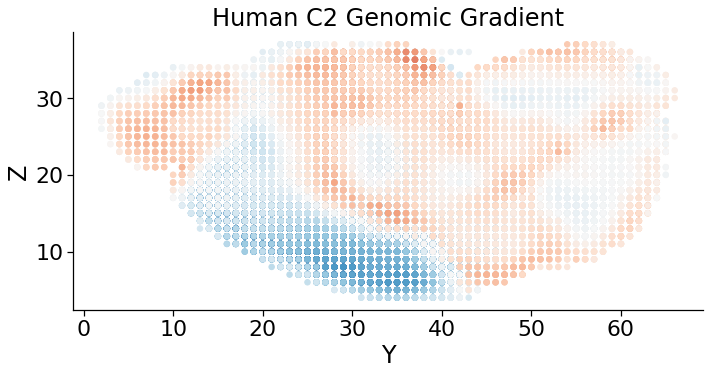

In [72]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.colors import Normalize


cmap = sns.color_palette('RdBu_r',as_cmap=True)

for i in range(1,4):
    #if i == 2:
    sg = np.dot(homocomp['HumanC%s'%i].values,hexp)
    #else:
    #    sg = -gdf.loc[:,'Component%s_Expresion'%(i+1)].values
    scaled_sg = MinMaxScaler().fit_transform(sg.reshape(-1,1))[:,0]
    norm = Normalize(vmin=np.min(scaled_sg), 
                                       vmax=np.max(scaled_sg))
    cscale = cmap(norm(scaled_sg))

    g = sns.lmplot(x='y', y='z', aspect=2, 
                   data=vdf, fit_reg=False, 
                   scatter_kws={"s": 30,'color':cscale},
                  palette='RdBu_r')
    
    plt.xlabel('Y')
    plt.ylabel('Z')
    plt.title('Human C%s Genomic Gradient'%(i))
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#     plt.ylim(-85,90)
#     plt.xlim(-115,75)
#     plt.xticks([-100,-50,0,50])
#     plt.yticks(list(range(-75,76,25)))
#     plt.savefig('/Users/jacobv/Science/PLS_GXP/txfer/ManuFigs/brain_plot_GenomicC%s_YZ.pdf'%(i+1),
#                bbox_inches='tight')



In [39]:
coords.shape

(24044, 3)

In [40]:
from sklearn.preprocessing import MinMaxScaler

cmap = sns.color_palette('RdBu_r',as_cmap=True)

for i in range(1,4):
    #if i == 2:
    sg = np.dot(homocomp['HumanC%s'%i].values,hexp)
    #else:
    #    sg = -gdf.loc[:,'Component%s_Expresion'%(i+1)].values
    scaled_sg = MinMaxScaler().fit_transform(sg.reshape(-1,1))[:,0]
    norm = Normalize(vmin=np.min(scaled_sg), 
                                       vmax=np.max(scaled_sg))
    cscale = cmap(norm(scaled_sg))

    g = sns.lmplot(x='y', y='x', aspect=2, 
                   data=vdf, fit_reg=False, 
                   scatter_kws={"s": 30,'color':cscale},
                  palette='RdBu_r')
    
    plt.xlabel('Y')
    plt.ylabel('X')
    plt.title('Human C%s Genomic Gradient'%(i))
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#     plt.ylim(-85,90)
#     plt.xlim(-115,75)
#     plt.xticks([-100,-50,0,50])
#     plt.yticks(list(range(-75,76,25)))
#     plt.savefig('/Users/jacobv/Science/PLS_GXP/txfer/ManuFigs/brain_plot_GenomicC%s_YZ.pdf'%(i+1),
#                bbox_inches='tight')



NameError: name 'homocomp' is not defined

In [255]:
hexp.to_csv('/Users/jacobv/Dropbox/Work/Projects/PLS_ABA/PLS_GXP_CollabSpace/Mouse_GXp_matrix.csv')

#### Spatial comparison

In [77]:
spatial_exp = pandas.DataFrame(columns=homocomp.columns)
for col in homocomp.columns:
    spatial_exp.loc[:,col] = np.dot(homocomp[col].values,hexp)

In [85]:
sns.set_context('notebook',font_scale=1)
sns.heatmap(pandas.DataFrame(np.corrcoef(spatial_exp.T),
                            index=homocomp.columns,columns=homocomp.columns),
            center=0,annot=True,cmap='RdBu_r')

<AxesSubplot:>